# Machine Learning Homework

_@author: Lucian Grigore_

# Setup

In [ ]:
# downloading datasets
! wget https://www.timeseriesclassification.com/Downloads/UWaveGestureLibrary.zip
! wget https://www.timeseriesclassification.com/Downloads/PEMS-SF.zip
! mkdir UWaveGestureLibrary && PEMS-SF
! unzip UWaveGestureLibrary.zip -d ./UWaveGestureLibrary
! unzip PEMS-SF.zip -d ./PEMS-SF

--2022-05-22 19:38:16--  https://www.timeseriesclassification.com/Downloads/UWaveGestureLibrary.zip
Resolving www.timeseriesclassification.com (www.timeseriesclassification.com)... 109.123.71.232
Connecting to www.timeseriesclassification.com (www.timeseriesclassification.com)|109.123.71.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2972926 (2.8M) [application/zip]
Saving to: ‘UWaveGestureLibrary.zip’

UWaveGestureLibrary 100%[===================>]   2.83M  3.01MB/s    in 0.9s    

2022-05-22 19:38:18 (3.01 MB/s) - ‘UWaveGestureLibrary.zip’ saved [2972926/2972926]

--2022-05-22 19:38:18--  https://www.timeseriesclassification.com/Downloads/PEMS-SF.zip
Resolving www.timeseriesclassification.com (www.timeseriesclassification.com)... 109.123.71.232
Connecting to www.timeseriesclassification.com (www.timeseriesclassification.com)|109.123.71.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 327596807 (312M) [application/zip]
Saving

In [ ]:
# importing libraries
! pip install sktime tensorflow pandas sklearn xgboost seaborn scipy stats
import os
import sktime
import sklearn
import warnings
import scipy.stats as stats
import numpy as np
import pandas as pd
import tensorflow as tf
import xgboost as xg
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sktime.datasets import load_from_tsfile_to_dataframe
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from seaborn import barplot
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Activation, Dropout, Conv1D, MaxPool1D, Concatenate, BatchNormalization, Activation, Add, GlobalAveragePooling1D, LSTM, GlobalMaxPooling1D
warnings.filterwarnings('ignore')

     |████████████████████████████████| 6.7 MB 7.2 MB/s 
     |████████████████████████████████| 127 kB 45.7 MB/s 
     |████████████████████████████████| 3.3 MB 30.0 MB/s 
     |████████████████████████████████| 9.8 MB 33.8 MB/s 
     |████████████████████████████████| 34.5 MB 4.6 kB/s 
     |████████████████████████████████| 462 kB 51.5 MB/s 
  Created wheel for stats: filename=stats-0.1.2a0-py3-none-any.whl size=24299 sha256=8124610ace3aa7584f63dc3ed5eadc8f26d63ce561d853a408254d7d52463b59
  Stored in directory: /root/.cache/pip/wheels/e3/1c/58/620049eecc13fb5b4920470895e07a39f86e889a0a58b11976
Successfully built stats
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Attempting uninstall: numba
   

In [ ]:
# importing datasets
uwave_train_x, uwave_train_y = load_from_tsfile_to_dataframe("./UWaveGestureLibrary/UWaveGestureLibrary_TRAIN.ts")
uwave_test_x, uwave_test_y = load_from_tsfile_to_dataframe("./UWaveGestureLibrary/UWaveGestureLibrary_TEST.ts")
pems_train_x, pems_train_y = load_from_tsfile_to_dataframe("./PEMS-SF/PEMS-SF_TRAIN.ts")
pems_test_x, pems_test_y = load_from_tsfile_to_dataframe("./PEMS-SF/PEMS-SF_TEST.ts")

temp = uwave_train_x
uwave_train_x = uwave_test_x
uwave_test_x = temp

temp = uwave_train_y
uwave_train_y = uwave_test_y
uwave_test_y = temp

print(uwave_train_x.shape)
print(uwave_test_x.shape)
print(uwave_train_y.shape)
print(uwave_test_y.shape)
print(pems_train_x.shape)
print(pems_test_x.shape)

(320, 3)
(120, 3)
(320,)
(120,)
(267, 963)
(173, 963)


# 1. Exploratory Data Analysis

## UWaveGesture Dataset

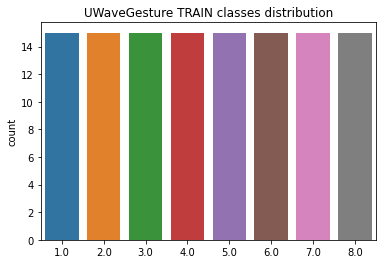

In [ ]:
plt.title('UWaveGesture TRAIN classes distribution')
sns.set_style('whitegrid')
ax = sns.countplot(x=uwave_train_y)

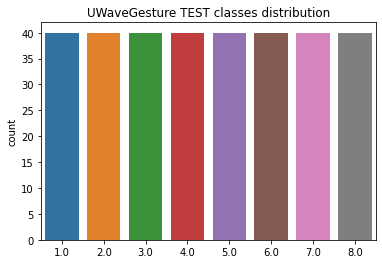

In [ ]:
plt.title('UWaveGesture TEST classes distribution')
sns.set_style('whitegrid')
ax = sns.countplot(x=uwave_test_y)

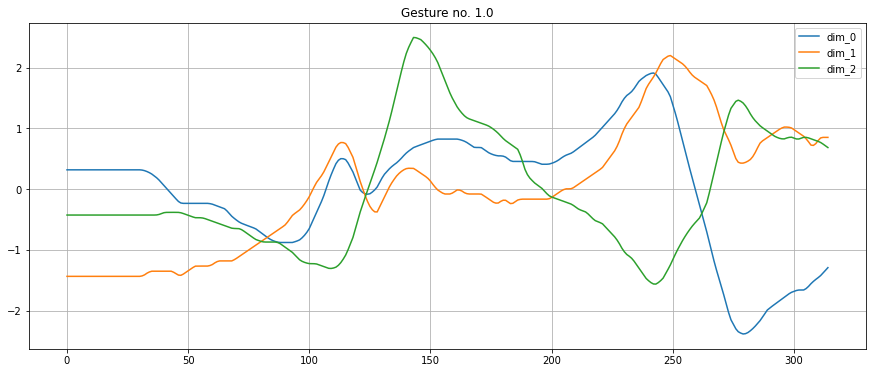

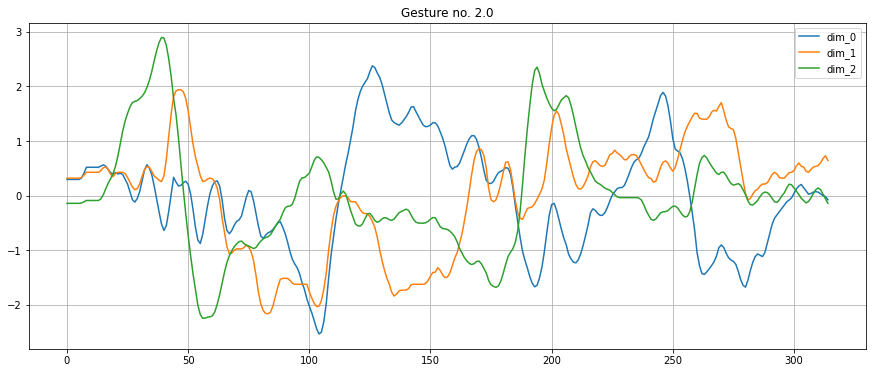

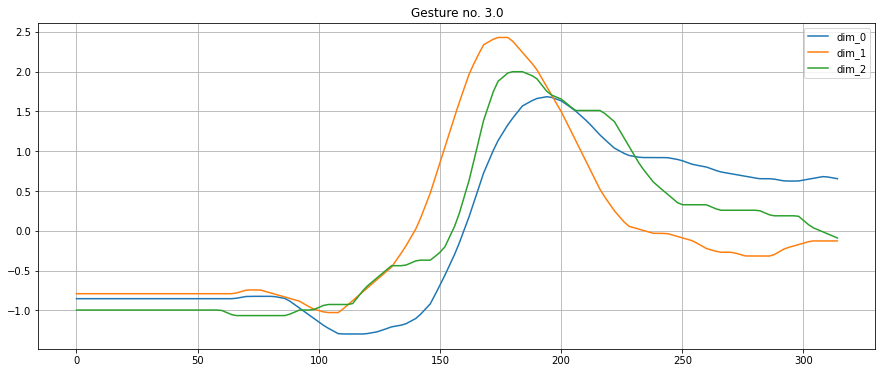

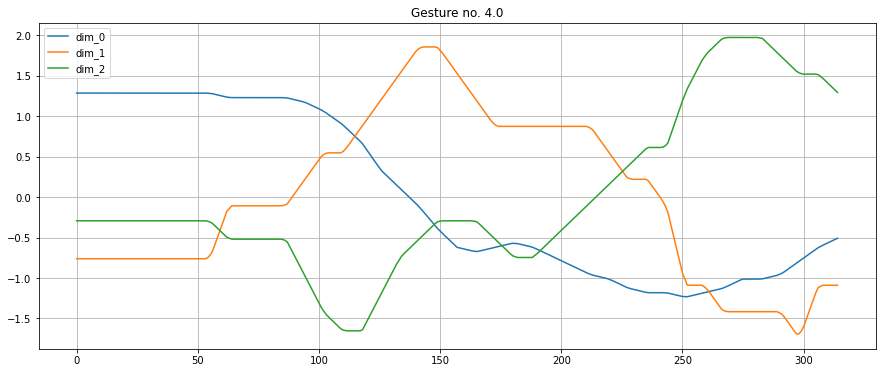

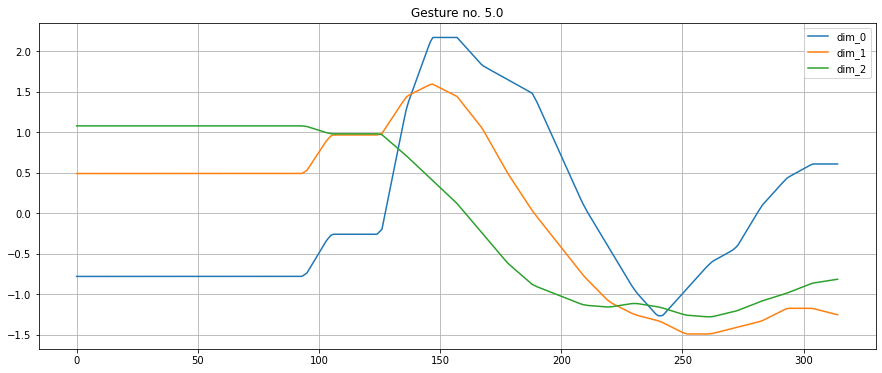

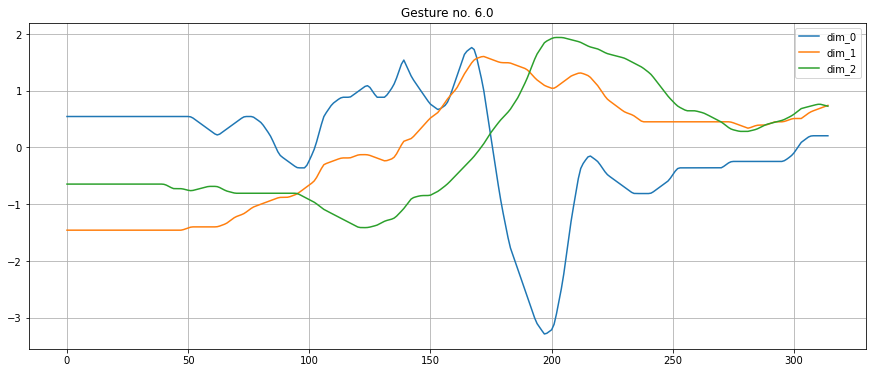

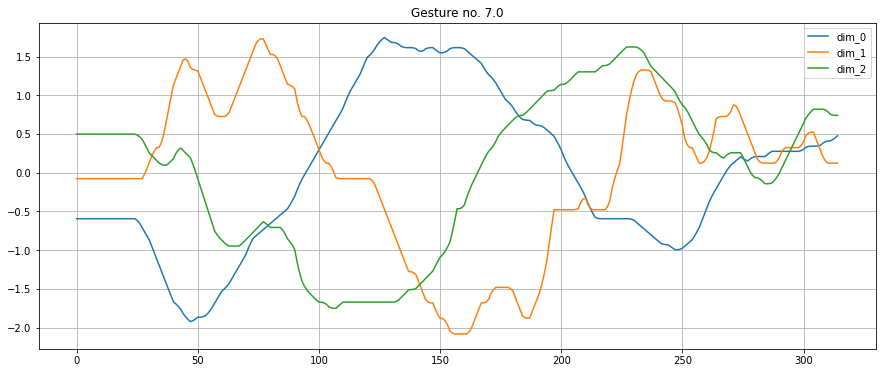

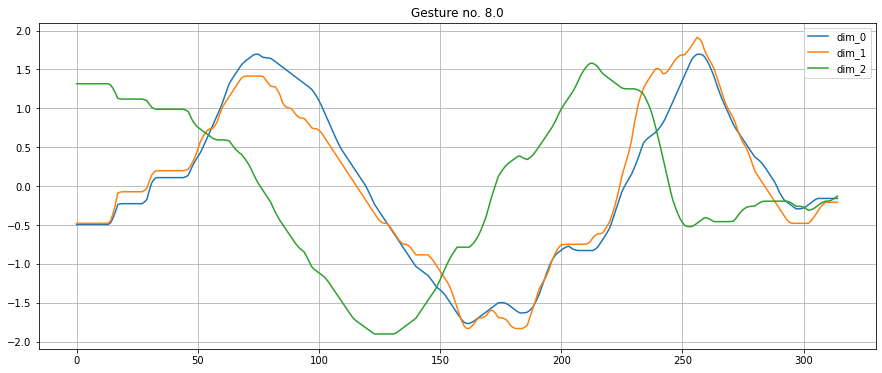

In [ ]:
for i in ['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0']:
    plt.figure(figsize=(15, 6))
    data_sample = uwave_train_x[uwave_train_y == i]
    sns.lineplot(data=data_sample.iat[0, 0])
    sns.lineplot(data=data_sample.iat[0, 1])
    sns.lineplot(data=data_sample.iat[0, 2])
    plt.title(f'Gesture no. {i}')
    plt.legend(['dim_0', 'dim_1', 'dim_2'])
    plt.grid()
    plt.show()

In [ ]:
uwave_df = pd.DataFrame(columns=['idx', 'x-axis', 'y-axis', 'z-axis', 'gesture'], dtype=object)

x_axis, y_axis, z_axis, gesture = [], [], [], []

for idx in range(uwave_train_x.shape[0]):
    x_axis += uwave_train_x.iat[idx, 0].tolist()
    y_axis += uwave_train_x.iat[idx, 1].tolist()
    z_axis += uwave_train_x.iat[idx, 2].tolist()
    gesture += [uwave_train_y[idx]] * uwave_train_x.iat[idx, 0].shape[0]

uwave_df['x-axis'] = np.array(x_axis)
uwave_df['y-axis'] = np.array(y_axis)
uwave_df['z-axis'] = np.array(z_axis)
uwave_df['gesture'] = np.array(gesture)
uwave_df['idx'] = np.asarray(range(0, len(uwave_df)))

print(uwave_df.shape)
print(uwave_df.head())

(37800, 5)
   idx   x-axis  y-axis   z-axis gesture
0    0  0.31745 -1.4345 -0.42612     1.0
1    1  0.31745 -1.4345 -0.42612     1.0
2    2  0.31745 -1.4345 -0.42612     1.0
3    3  0.31745 -1.4345 -0.42612     1.0
4    4  0.31745 -1.4345 -0.42612     1.0


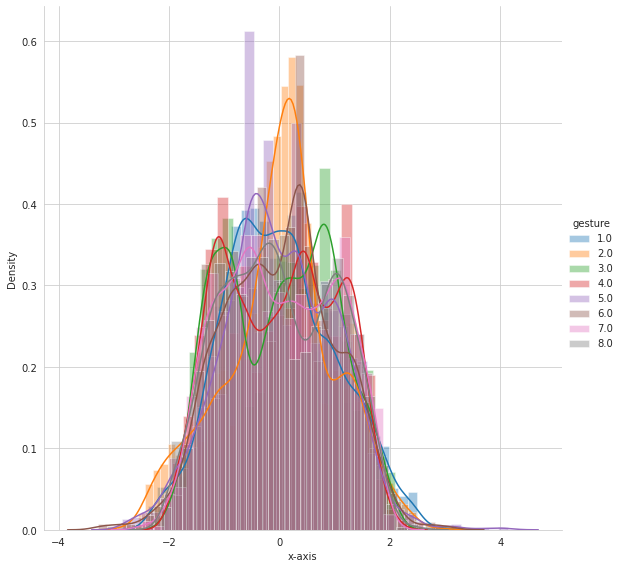

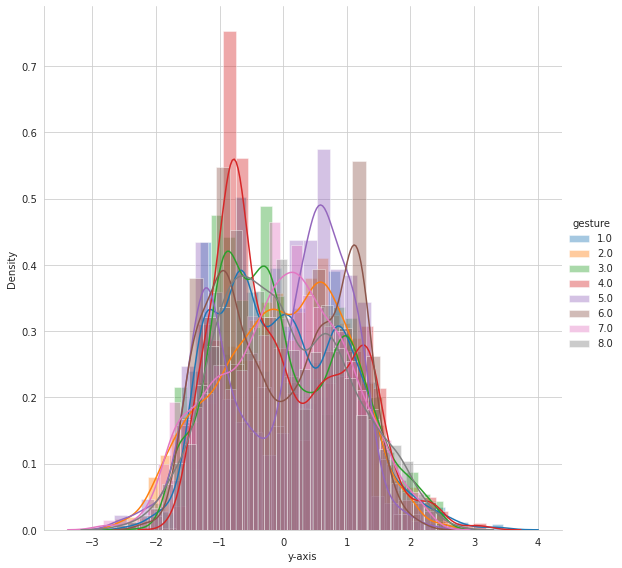

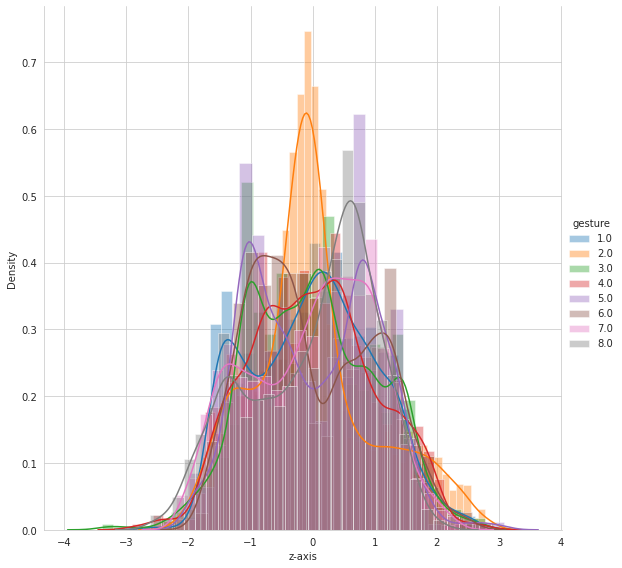

In [ ]:
sns.set_style('whitegrid')
sns.FacetGrid(uwave_df, hue='gesture', size = 8).map(sns.distplot, 'x-axis').add_legend()
sns.FacetGrid(uwave_df, hue='gesture', size = 8).map(sns.distplot, 'y-axis').add_legend()
sns.FacetGrid(uwave_df, hue='gesture', size = 8).map(sns.distplot, 'z-axis').add_legend()

## PEMS-SF Dataset

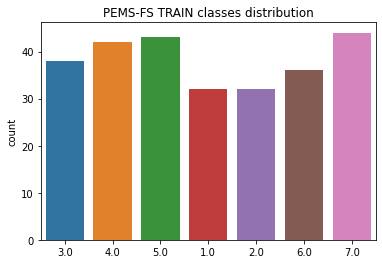

In [ ]:
plt.title('PEMS-FS TRAIN classes distribution')
sns.set_style('whitegrid')
ax = sns.countplot(x=pems_train_y)

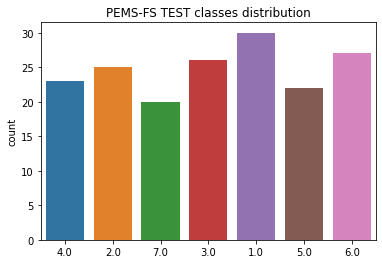

In [ ]:
plt.title('PEMS-FS TEST classes distribution')
sns.set_style('whitegrid')
ax = sns.countplot(x=pems_test_y)

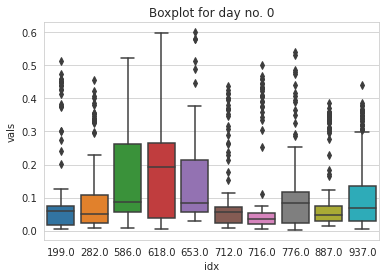

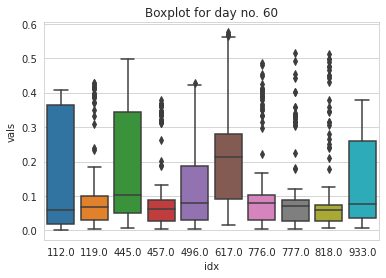

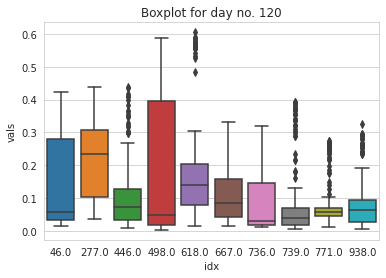

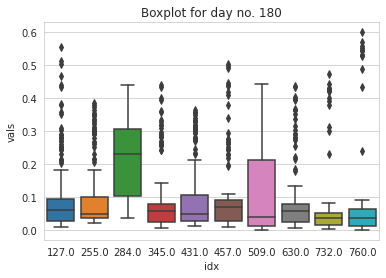

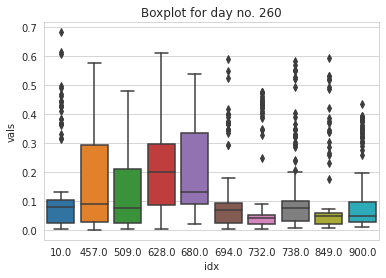

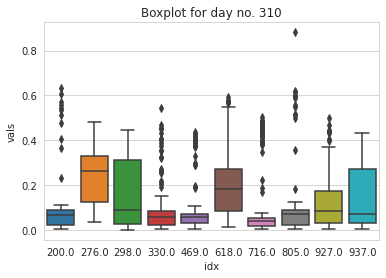

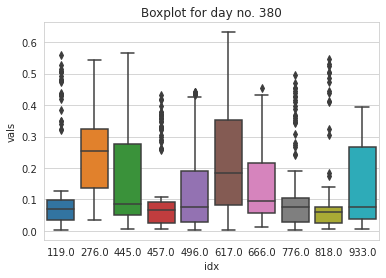

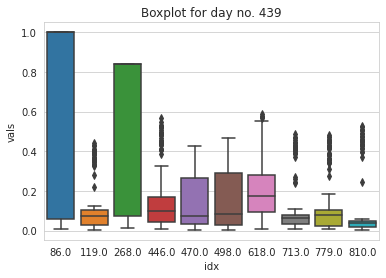

In [ ]:
pems_df_x = pd.concat([pems_train_x, pems_test_x], ignore_index=True)

for day_no in [0, 60, 120, 180, 260, 310, 380, 439]:
    devs = []
    for sensor_idx in range(963):
        devs.append((sensor_idx, pems_df_x.iat[day_no, sensor_idx].std()))
    devs.sort(key=lambda x: x[1], reverse=True)
    
    df = pd.DataFrame(columns=['idx', 'vals'], dtype=object)
    for i in range(10):
        for j in range(144):
            df = df.append({'idx': devs[i][0], 'vals' : pems_df_x.iat[day_no, devs[i][0]].tolist()[j]}, ignore_index=True)

    sns.boxplot(x='idx', y='vals', data=df)
    plt.title(f'Boxplot for day no. {day_no}')
    plt.show()

In [ ]:
meds = []
for sensor_idx in range(963):
    lst = []
    for day_no in range(440):
        lst.append(pems_df_x.iat[day_no, sensor_idx].mean())
    meds.append((sensor_idx, np.std(lst), lst))
meds.sort(key=lambda x: x[1])

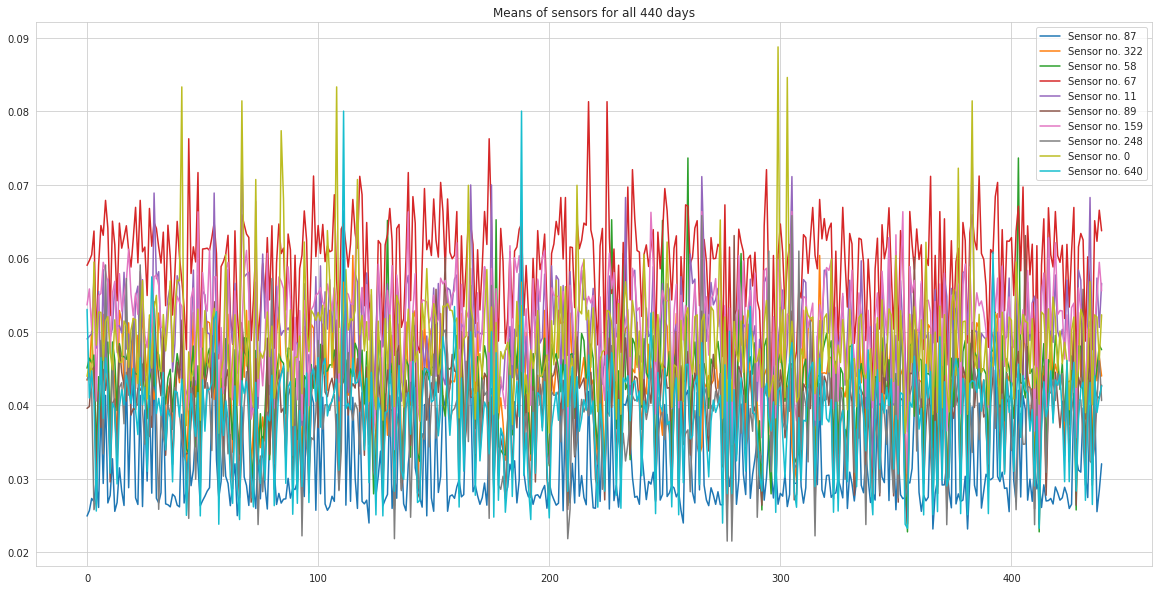

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(10):
    sns.lineplot(data=meds[i][2])
plt.title(f'Means of 10 most relevant sensors for all 440 days')
plt.legend([f'Sensor no. {i}' for i in [meds[j][0] for j in range(10)]])
plt.show()

# 2. Atribute extraction and training ML models

## UWaveGesture Dataset

In [ ]:
# extracting means from value windows of length 105 for each axis individually
# that is reducing the data for one single entry to 9 values

uwave_df_train_y_map = map(lambda x: float(x), uwave_train_y)
uwave_df_test_y_map = map(lambda x: float(x), uwave_test_y)
vals = []
for x in uwave_df_train_y_map:
    vals.append(x - 1)
uwave_df_train_y = np.asarray(vals)

vals = []
for x in uwave_df_test_y_map:
    vals.append(x - 1)
uwave_df_test_y = np.asarray(vals)

uwave_df_train_x = pd.DataFrame(columns = [str(i) for i in range(9)])
uwave_df_test_x = pd.DataFrame(columns = [str(i) for i in range(9)])

vals = [[] for _ in range(9)]
for i in range(uwave_train_x.shape[0]):
    vals[0].append(uwave_train_x.iat[i, 0].to_numpy()[:105].mean())
    vals[1].append(uwave_train_x.iat[i, 0].to_numpy()[105:210].mean())
    vals[2].append(uwave_train_x.iat[i, 0].to_numpy()[210:315].mean())

    vals[3].append(uwave_train_x.iat[i, 1].to_numpy()[:105].mean())
    vals[4].append(uwave_train_x.iat[i, 1].to_numpy()[105:210].mean())
    vals[5].append(uwave_train_x.iat[i, 1].to_numpy()[210:315].mean())

    vals[6].append(uwave_train_x.iat[i, 2].to_numpy()[:105].mean())
    vals[7].append(uwave_train_x.iat[i, 2].to_numpy()[105:210].mean())
    vals[8].append(uwave_train_x.iat[i, 2].to_numpy()[210:315].mean())
for i in [str(j) for j in range(9)]:
    uwave_df_train_x[i] = vals[int(i)]

vals = [[] for _ in range(9)]
for i in range(uwave_test_x.shape[0]):
    vals[0].append(uwave_test_x.iat[i, 0].to_numpy()[:105].mean())
    vals[1].append(uwave_test_x.iat[i, 0].to_numpy()[105:210].mean())
    vals[2].append(uwave_test_x.iat[i, 0].to_numpy()[210:315].mean())

    vals[3].append(uwave_test_x.iat[i, 1].to_numpy()[:105].mean())
    vals[4].append(uwave_test_x.iat[i, 1].to_numpy()[105:210].mean())
    vals[5].append(uwave_test_x.iat[i, 1].to_numpy()[210:315].mean())

    vals[6].append(uwave_test_x.iat[i, 2].to_numpy()[:105].mean())
    vals[7].append(uwave_test_x.iat[i, 2].to_numpy()[105:210].mean())
    vals[8].append(uwave_test_x.iat[i, 2].to_numpy()[210:315].mean())
for i in [str(j) for j in range(9)]:
    uwave_df_test_x[i] = vals[int(i)]

print(uwave_df_train_x.shape)
print(uwave_df_test_x.shape)
print(uwave_df_train_x.head())
print(uwave_df_test_x.head())

print(uwave_df_train_y)

(320, 9)
(120, 9)
          0         1         2         3         4         5         6  \
0 -0.297342  1.053787 -0.756444 -1.184048  0.298630  0.885416 -1.045485   
1 -0.590103  0.939729 -0.349624 -1.067954  0.207586  0.860378 -0.695985   
2  0.071250 -0.481380  0.410131 -0.649458 -0.415358  1.064816 -1.176571   
3 -0.134842  0.658654 -0.523816 -0.917658 -0.119713  1.037375 -0.117889   
4  0.036967  1.052105 -1.089073 -1.026782 -0.221545  1.248322 -1.237256   

          7         8  
0  0.671346  0.374121  
1 -0.103015  0.799004  
2  0.326615  0.849956  
3 -0.031694  0.149579  
4  0.905670  0.331575  
          0         1         2         3         4         5         6  \
0 -0.189455  0.483561 -0.294104 -1.109946  0.041144  1.068795 -0.617093   
1 -0.299745  0.856915 -0.557168 -0.959348 -0.293975  1.253311 -1.063503   
2 -0.725299  0.999003 -0.273685  0.412872 -0.532712  0.119843 -0.586153   
3 -0.046706  0.217342 -0.170640 -0.721934 -0.578523  1.300457 -1.087310   
4 -0.709654 

In [ ]:
# feature selection
sp = SelectPercentile(percentile=50)
sp.fit(uwave_df_train_x.to_numpy(), uwave_df_train_y)
uwave_df_train_x_arr = sp.transform(uwave_df_train_x.to_numpy())
uwave_df_test_x_arr = sp.transform(uwave_df_test_x.to_numpy())

In [ ]:
x_axis, y_axis, z_axis = [], [], []
for i in range(len(uwave_df_train_x)):
    x_axis.append(uwave_df_train_x.iloc[i, 0])
    x_axis.append(uwave_df_train_x.iloc[i, 1])
    x_axis.append(uwave_df_train_x.iloc[i, 2])

    y_axis.append(uwave_df_train_x.iloc[i, 3])
    y_axis.append(uwave_df_train_x.iloc[i, 4])
    y_axis.append(uwave_df_train_x.iloc[i, 5])

    z_axis.append(uwave_df_train_x.iloc[i, 6])
    z_axis.append(uwave_df_train_x.iloc[i, 7])
    z_axis.append(uwave_df_train_x.iloc[i, 8])

for i in range(len(uwave_df_test_x)):
    x_axis.append(uwave_df_test_x.iloc[i, 0])
    x_axis.append(uwave_df_test_x.iloc[i, 1])
    x_axis.append(uwave_df_test_x.iloc[i, 2])

    y_axis.append(uwave_df_test_x.iloc[i, 3])
    y_axis.append(uwave_df_test_x.iloc[i, 4])
    y_axis.append(uwave_df_test_x.iloc[i, 5])

    z_axis.append(uwave_df_test_x.iloc[i, 6])
    z_axis.append(uwave_df_test_x.iloc[i, 7])
    z_axis.append(uwave_df_test_x.iloc[i, 8])

x_axis = np.asarray(x_axis)
y_axis = np.asarray(y_axis)
z_axis = np.asarray(z_axis)

In [ ]:
axes = {
    'x_axis': x_axis,
    'y_axis': y_axis,
    'z_axis': z_axis
}

analysers = {
    'mean': lambda x: x.mean(),
    'std': lambda x: x.std(),
    'avg absolute diff': lambda x: np.mean(np.absolute(x - np.mean(x))),
    'min': lambda x: x.min(),
    'max': lambda x: x.max(),
    'max-min diff': lambda x: x.max() - x.min(),
    'median': lambda x: np.median(x),
    'median abs dev': lambda x: np.median(np.absolute(x - np.median(x))),
    'IQR': lambda x: np.percentile(x, 75) - np.percentile(x, 25),
    'negative count': lambda x: np.sum(x > 0),
    'positive count': lambda x: np.sum(x < 0),
    'values above mean': lambda x: np.sum(x > x.mean()),
    'values below mean': lambda x: np.sum(x < x.mean()),
    'number of peaks': lambda x: len(find_peaks(x)[0]),
    'skewness': lambda x: stats.skew(x),
    'kurtosis': lambda x: stats.kurtosis(x),
    'energy': lambda x: np.sum(x ** 2 / 100) 
}

In [ ]:
for analyser, f in analysers.items():
    for axe, v in axes.items():
        print(f'Applying {analyser} on {axe}: {f(v)}')
print(f'Average resultant acc is {np.sum([pd.Series(axe) ** 2 for axe in axes.values()]) ** 0.5}')
print(f'Signal magnitude area is {np.sum([pd.Series(axe).apply(lambda x: abs(x) / len(axe)) for axe in axes.values()])}')

Applying mean on x_axis: -1.1325396825710079e-07
Applying mean on y_axis: -1.191991341994739e-07
Applying mean on z_axis: -2.6096681093963078e-08
Applying std on x_axis: 0.6537793630419304
Applying std on y_axis: 0.7495870421412952
Applying std on z_axis: 0.7088489128654653
Applying avg absolute diff on x_axis: 0.5317972085502645
Applying avg absolute diff on y_axis: 0.6496156217923061
Applying avg absolute diff on z_axis: 0.6049543094942061
Applying min on x_axis: -1.363360857142857
Applying min on y_axis: -1.3331605714285715
Applying min on z_axis: -1.3638615238095237
Applying max on x_axis: 1.360968380952381
Applying max on y_axis: 1.3764914000000001
Applying max on z_axis: 1.33198819047619
Applying max-min diff on x_axis: 2.7243292380952377
Applying max-min diff on y_axis: 2.7096519714285714
Applying max-min diff on z_axis: 2.695849714285714
Applying median on x_axis: -0.02353086190476192
Applying median on y_axis: 0.03759409047619046
Applying median on z_axis: 0.09206555714285715


## PEMS-SF Dataset

In [ ]:
pems_df_x = pd.concat([pems_train_x, pems_test_x], ignore_index=True)
pems_df_y = pd.DataFrame([pems_train_x, pems_test_y])

mat = []

for day_no in [0, 60, 120, 180, 260, 310, 380, 439]:
    devs = []
    for sensor_idx in range(963):
        devs.append((sensor_idx, pems_df_x.iat[day_no, sensor_idx].std()))
    devs.sort(key=lambda x: x[1], reverse=True)

    mat.append(pems_df_x.iloc[day_no, sensor_idx].to_list()) 
mat = np.array(mat)   

In [ ]:
sp = SelectPercentile(percentile=50)
sp.fit(pems_df_x.to_numpy(), pems_df_y)
pems_df_x_arr = sp.transform(pems_df_x.to_numpy())

In [ ]:
analysers = {
    'mean': lambda x: x.mean(),
    'std': lambda x: x.std(),
    'min': lambda x: x.min(),
    'max': lambda x: x.max(),
    'median': lambda x: np.median(x),
    'max-min diff': lambda x: x.max() - x.min(),
    'IQR': lambda x: np.percentile(x, 75) - np.percentile(x, 25),
    'number of peaks': lambda x: len(find_peaks(x)[0]),
    'skewness': lambda x: stats.skew(x),
    'kurtosis': lambda x: stats.kurtosis(x)
}

sensors = [0, 60, 120, 180, 260, 310, 380, 439]

In [ ]:
for i, day_idx in enumerate(sensors):
    print(f'Analyzing day number {day_idx}.')
    for name, f in analysers.items():
        print(f'\t{name}: {f(mat[i])}')
    print('\n')

Analyzing day number 0.
	mean: 0.06314583333333333
	std: 0.054040430948349524
	min: 0.0
	max: 0.329
	median: 0.0521
	max-min diff: 0.329
	IQR: 0.05985
	number of peaks: 42
	skewness: 1.926261696888133
	kurtosis: 5.106245282031292


Analyzing day number 60.
	mean: 0.07126944444444444
	std: 0.04268916932278181
	min: 0.0083
	max: 0.156
	median: 0.07645
	max-min diff: 0.1477
	IQR: 0.06155000000000001
	number of peaks: 30
	skewness: 0.10068100566356297
	kurtosis: -1.050568312492597


Analyzing day number 120.
	mean: 0.07384791666666667
	std: 0.04277140134993825
	min: 0.0139
	max: 0.2958
	median: 0.06820000000000001
	max-min diff: 0.2819
	IQR: 0.055900000000000005
	number of peaks: 36
	skewness: 1.3309766490412855
	kurtosis: 3.9871911679885024


Analyzing day number 180.
	mean: 0.04743819444444444
	std: 0.024580166452875786
	min: 0.0077
	max: 0.092
	median: 0.048350000000000004
	max-min diff: 0.0843
	IQR: 0.04625
	number of peaks: 44
	skewness: -0.03183009884987836
	kurtosis: -1.361331748051

## Model Training

In [ ]:
def svm(model_name, performance, X, y):
    params = {
        'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
        'C' : [0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75,  1.0, 2.0, 3.0]
    }
    model = SVC()
    gs = GridSearchCV(estimator = model, param_grid=params)
    gs.fit(X, y)
    performance[model_name] = gs


def rf(model_name, performance, X, y):
    params = [{
        'n_estimators' : [10, 50, 100, 150, 250],
        'max_depth' : [None, 5, 10, 15, 50, 100],
        'bootstrap' : [False]
    },
    {
        'n_estimators' : [10, 50, 100, 150, 250],
        'max_depth' : [None, 5, 10, 15, 50, 100],
        'bootstrap' : [False],
        'max_samples' : [10, 20, 50, 100]  
    }]
    model = RandomForestClassifier()
    gs = GridSearchCV(estimator = model, param_grid=params)
    gs.fit(X, y)
    performance[model_name] = gs


def gbt(model_name, performance, X, y):
    params = {
        'n_estimators' : [10, 50, 100, 150, 250],
        'max_depth' : [1, 2, 3, 5, 10],
        'learning_rate' : [0.05, 0.1, 0.15, 0.2, 0.5]
    }
    model = GradientBoostingClassifier()
    gs = GridSearchCV(estimator = model, param_grid=params)
    gs.fit(X, y)
    performance[model_name] = gs

In [ ]:
models = [
    'Random Forest',
    'SVM',
    'XGBoost'
]

funcs = {
    'Random Forest' : rf,
    'SVM' : svm,
    'XGBoost' : gbt
}

In [ ]:
def run_models(X, y, performance={}):
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    for model in models:
        print(f'Training {model} classifier... ', end='')
        funcs[model](model, performance, X, y)
        print(f'Done!')
    return performance

In [ ]:
def print_performances(performance, verbose=False):
    for model in models:
        print(f'--- Performance Analysis for {model} classifier ---')
        if verbose:
            print(f'Complete results for all tried configurations of model {model}:')
            print(performance[model].cv_results_)
        print(f'Best accuracy was {performance[model].best_score_}\n\twith params {performance[model].best_params_}')
        print('\n')

In [ ]:
uwave_performance = run_models(uwave_df_train_x, uwave_df_train_y)

Training Random Forest classifier... Done!
Training SVM classifier... Done!
Training XGBoost classifier... Done!


In [ ]:
print_performances(uwave_performance)

--- Performance Analysis for Random Forest classifier ---
Best accuracy was 0.8
	with params {'bootstrap': False, 'max_depth': 50, 'n_estimators': 50}


--- Performance Analysis for SVM classifier ---
Best accuracy was 0.8333333333333334
	with params {'C': 0.15, 'kernel': 'rbf'}


--- Performance Analysis for XGBoost classifier ---
Best accuracy was 0.7333333333333333
	with params {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 150}




In [ ]:
for model in models:
    print(f'--- Performance Analysis for {model} classifier ---')
    results = uwave_performance[model]
    print(f'\tBest parameter combination {results.best_params_}')
    y_pred = results.best_estimator_.predict(uwave_df_test_x)
    print(f'\tGeneral accuracy: {accuracy_score(uwave_df_test_y, y_pred)}')
    print(f'\tPrecision: {precision_score(uwave_df_test_y, y_pred, average=None)}')
    print(f'\tRecall: {recall_score(uwave_df_test_y, y_pred, average=None)}')
    print(f'\tF1: {f1_score(uwave_df_test_y, y_pred, average=None)}')
    print('\n\n')

--- Performance Analysis for Random Forest classifier ---
	Best parameter combination {'bootstrap': False, 'max_depth': 50, 'n_estimators': 50}
	General accuracy: 0.715625
	Precision: [0.73333333 0.65957447 0.67307692 0.91304348 0.67924528 0.8125
 0.65625    0.72222222]
	Recall: [0.825 0.775 0.875 0.525 0.9   0.65  0.525 0.65 ]
	F1: [0.77647059 0.71264368 0.76086957 0.66666667 0.77419355 0.72222222
 0.58333333 0.68421053]



--- Performance Analysis for SVM classifier ---
	Best parameter combination {'C': 0.15, 'kernel': 'rbf'}
	General accuracy: 0.809375
	Precision: [0.85365854 0.88095238 0.8372093  0.875      0.69090909 0.82857143
 0.90909091 0.72      ]
	Recall: [0.875 0.925 0.9   0.7   0.95  0.725 0.5   0.9  ]
	F1: [0.86419753 0.90243902 0.86746988 0.77777778 0.8        0.77333333
 0.64516129 0.8       ]



--- Performance Analysis for XGBoost classifier ---
	Best parameter combination {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 150}
	General accuracy: 0.725
	Precision: 

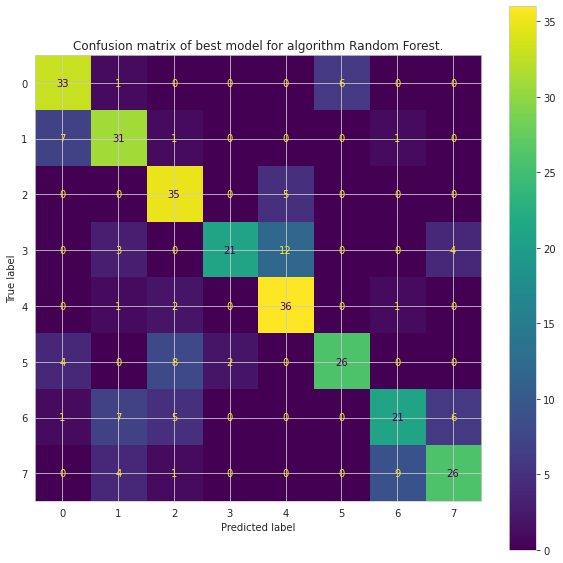

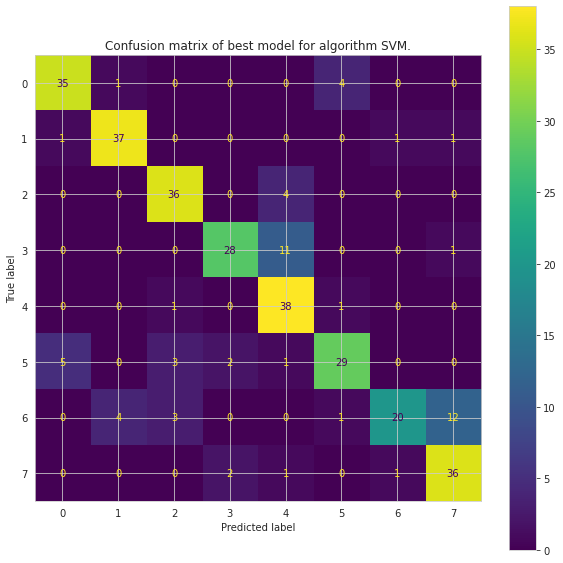

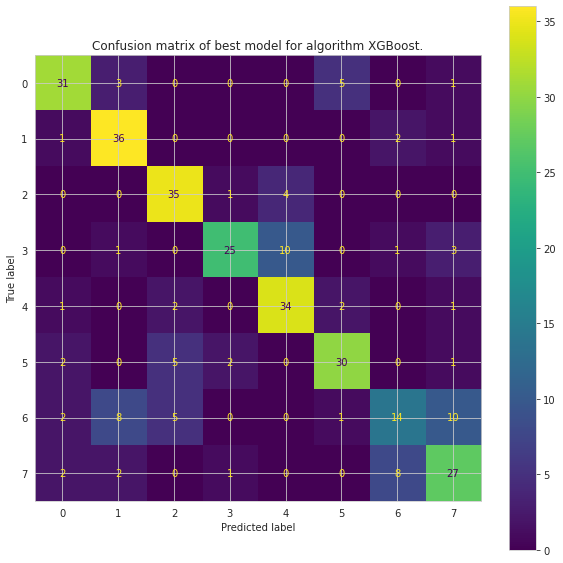

In [ ]:
for model in models:
    y_pred = uwave_performance[model].best_estimator_.predict(uwave_df_test_x)
    plt.figure(figsize=(10, 10))
    plt.title(f'Confusion matrix of best model for algorithm {model}.')
    ax = plt.axes()
    ConfusionMatrixDisplay(confusion_matrix(uwave_df_test_y, y_pred)).plot(ax=ax)

# 3. Neural networks

### Concatenating the different time-series for each entry

In [ ]:
mat = []
for i in range(len(uwave_train_x)):
    lst = []
    lst += uwave_train_x.iloc[i, 0].to_list()
    lst += uwave_train_x.iloc[i, 1].to_list()
    lst += uwave_train_x.iloc[i, 2].to_list()
    mat.append(lst)
mlp_train_x = pd.DataFrame(mat)

mat = []
for i in range(len(uwave_test_x)):
    lst = []
    lst += uwave_test_x.iloc[i, 0].to_list()
    lst += uwave_test_x.iloc[i, 1].to_list()
    lst += uwave_test_x.iloc[i, 2].to_list()
    mat.append(lst)
mlp_test_x = pd.DataFrame(mat)

## Multi-layer perceptron

In [ ]:
classifier = Sequential([
    Flatten(),
    Dropout(0.5),
    Dense(256, activation='sigmoid'),
    Dropout(0.5),
    Dense(128, activation='sigmoid'),
    Dropout(0.5),
    Dense(8, activation='softmax'),
])
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = classifier.fit(mlp_train_x, uwave_df_train_y, epochs=50, validation_split=0.1, batch_size=16)

Epoch 1/50
18/18 [==============================] - 1s 16ms/step - loss: 2.0156 - accuracy: 0.2431 - val_loss: 3.7381 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 0s 5ms/step - loss: 1.4067 - accuracy: 0.4931 - val_loss: 3.3582 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 0s 5ms/step - loss: 1.1515 - accuracy: 0.6146 - val_loss: 2.9444 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 0s 6ms/step - loss: 0.9501 - accuracy: 0.7083 - val_loss: 2.5626 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 0s 5ms/step - loss: 0.8651 - accuracy: 0.7326 - val_loss: 2.5161 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 0s 5ms/step - loss: 0.8237 - accuracy: 0.7535 - val_loss: 2.2232 - val_accuracy: 0.0938
Epoch 7/50
18/18 [==============================] - 0s 5ms/step - loss: 0.7588 - accuracy: 0.7500 - val_loss: 2.2504 - val_accuracy: 0.0312

In [ ]:
results = classifier.evaluate(mlp_test_x, uwave_df_test_y, verbose = 0)
print(f'Results on test set: loss={results[0]}, acc={results[1]}')

Results on test set: loss=0.4364376664161682, acc=0.8999999761581421


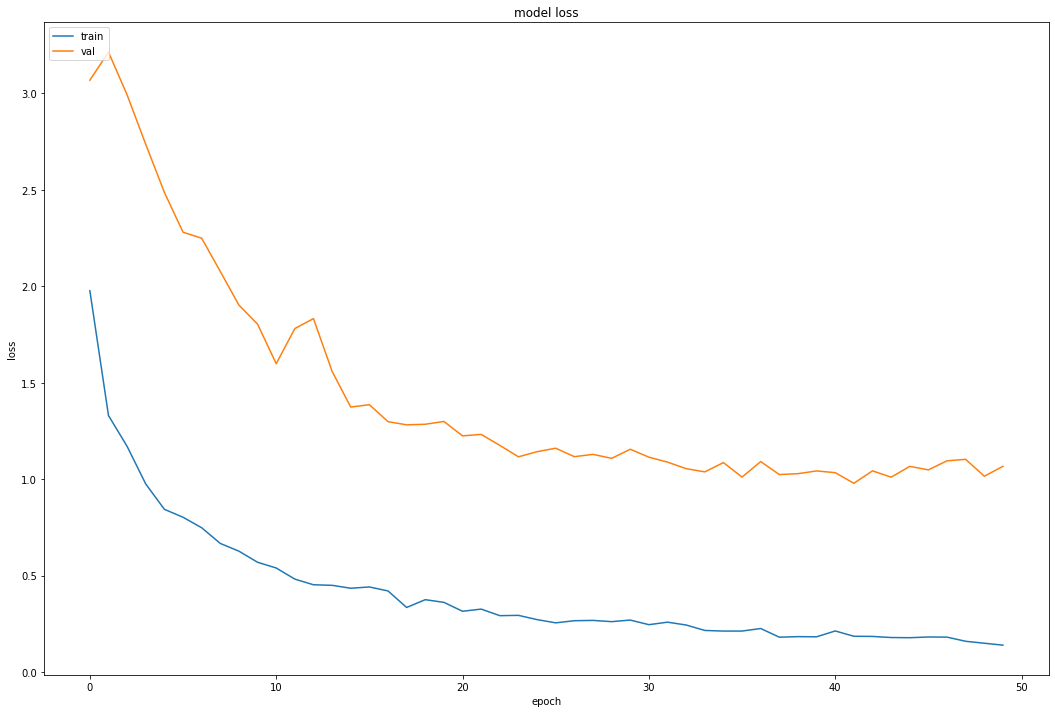

In [ ]:
plt.figure(figsize=(18,12))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

	General accuracy: 0.9
	Precision: [1.         0.9375     0.92857143 0.86666667 0.7        0.84615385
 1.         1.        ]
	Recall: [1.         1.         0.86666667 0.86666667 0.93333333 0.73333333
 1.         0.8       ]
	F1: [1.         0.96774194 0.89655172 0.86666667 0.8        0.78571429
 1.         0.88888889]





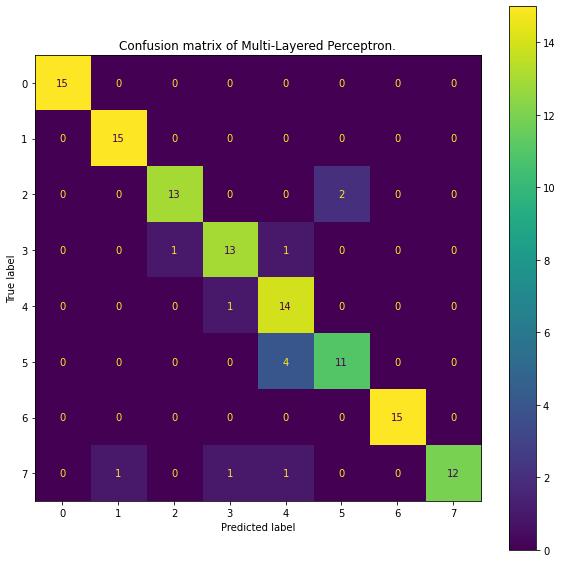

In [ ]:
y_pred = np.argmax(classifier.predict(mlp_test_x), axis=1)
print(f'General accuracy: {accuracy_score(uwave_df_test_y, y_pred)}')
print(f'Precision: {precision_score(uwave_df_test_y, y_pred, average=None)}')
print(f'Recall: {recall_score(uwave_df_test_y, y_pred, average=None)}')
print(f'F1: {f1_score(uwave_df_test_y, y_pred, average=None)}')
print('\n\n')
plt.figure(figsize=(10, 10))
plt.title(f'Confusion matrix of Multi-Layered Perceptron.')
ax = plt.axes()
ConfusionMatrixDisplay(confusion_matrix(uwave_df_test_y, y_pred)).plot(ax=ax)
plt.show()

## Convolutional Neural Network

In [ ]:
mat = []
for i in range(len(uwave_train_x)):
    lst = []
    for j in range(315):
        entry = []
        entry.append(uwave_train_x.iloc[i, 0].to_list()[j])
        entry.append(uwave_train_x.iloc[i, 1].to_list()[j])
        entry.append(uwave_train_x.iloc[i, 2].to_list()[j])
        lst += [entry]
    mat.append(lst)
cnn_train_x = np.array(mat)

mat = []
for i in range(len(uwave_test_x)):
    lst = []
    for j in range(315):
        entry = []
        entry.append(uwave_test_x.iloc[i, 0].to_list()[j])
        entry.append(uwave_test_x.iloc[i, 1].to_list()[j])
        entry.append(uwave_test_x.iloc[i, 2].to_list()[j])
        lst += [entry]
    mat.append(lst)
cnn_test_x = np.array(mat)

In [ ]:
print(cnn_train_x.shape)
cnn_train_y = tf.keras.utils.to_categorical(uwave_df_train_y)
cnn_test_y = tf.keras.utils.to_categorical(uwave_df_test_y)
print(cnn_train_y.shape)

(320, 315, 3)
(320, 8)


In [ ]:
classifier = Sequential([
    tf.keras.layers.Reshape((315, 3), input_shape=(315, 3)),
    Conv1D(filters=256, kernel_size=5, activation='relu', padding='same', input_shape=(315, 3)),
    Conv1D(filters=512, kernel_size=5, activation='relu'),
    tf.keras.layers.GlobalAvgPool1D(),
    Dense(1024, activation='relu'),
    Dense(256, activation='relu'),
    Dense(8, activation='softmax')
])

classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = classifier.fit(x=cnn_train_x, y=cnn_train_y, epochs=50, batch_size=16)

Epoch 1/50
20/20 [==============================] - 9s 414ms/step - loss: 2.0596 - accuracy: 0.1469
Epoch 2/50
20/20 [==============================] - 9s 444ms/step - loss: 1.8664 - accuracy: 0.2344
Epoch 3/50
20/20 [==============================] - 8s 419ms/step - loss: 1.7819 - accuracy: 0.2937
Epoch 4/50
20/20 [==============================] - 8s 423ms/step - loss: 1.6737 - accuracy: 0.3313
Epoch 5/50
20/20 [==============================] - 9s 427ms/step - loss: 1.5623 - accuracy: 0.4219
Epoch 6/50
20/20 [==============================] - 8s 424ms/step - loss: 1.5206 - accuracy: 0.3812
Epoch 7/50
20/20 [==============================] - 8s 417ms/step - loss: 1.3959 - accuracy: 0.4938
Epoch 8/50
20/20 [==============================] - 8s 421ms/step - loss: 1.2769 - accuracy: 0.5063
Epoch 9/50
20/20 [==============================] - 10s 495ms/step - loss: 1.2411 - accuracy: 0.5344
Epoch 10/50
20/20 [==============================] - 8s 416ms/step - loss: 1.2366 - accuracy: 0.531

In [ ]:
results = classifier.evaluate(cnn_test_x, cnn_test_y, verbose = 0)
print(f'Results on test set: loss={results[0]}, acc={results[1]}')

Results on test set: loss=1.19987154006958, acc=0.7583333253860474


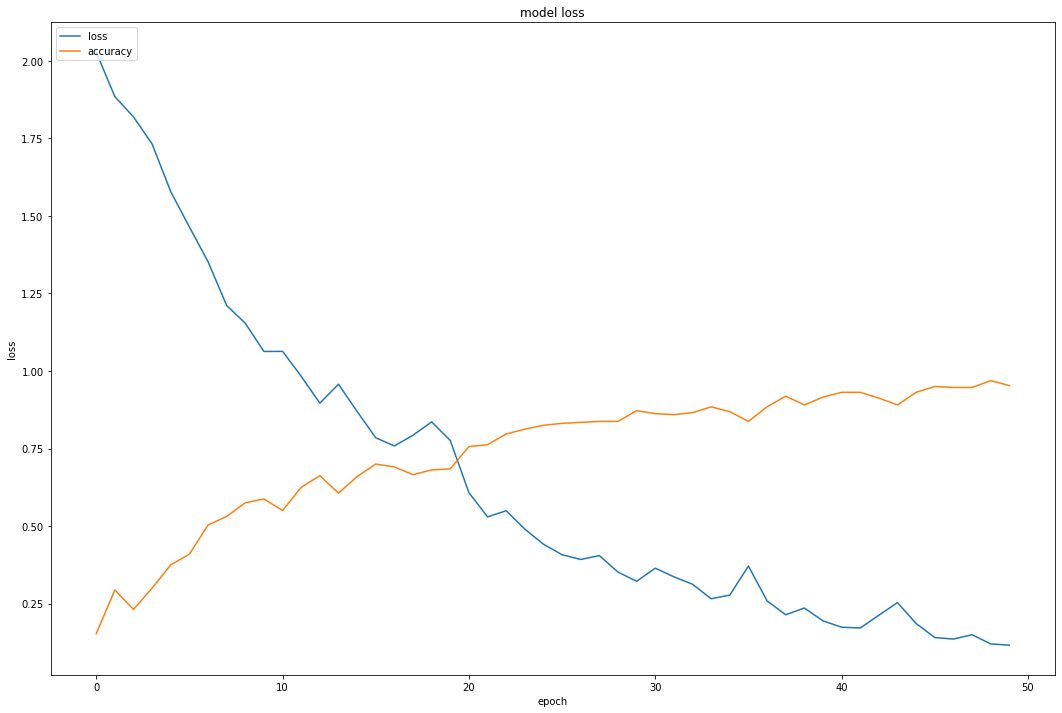

In [ ]:
plt.figure(figsize=(18,12))
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'], loc='upper left')
plt.show()

General accuracy: 0.775
Precision: [0.73333333 0.82352941 0.75       0.76923077 0.71428571 0.64285714
 0.8125     0.93333333]
Recall: [0.73333333 0.93333333 0.8        0.66666667 0.66666667 0.6
 0.86666667 0.93333333]
F1: [0.73333333 0.875      0.77419355 0.71428571 0.68965517 0.62068966
 0.83870968 0.93333333]





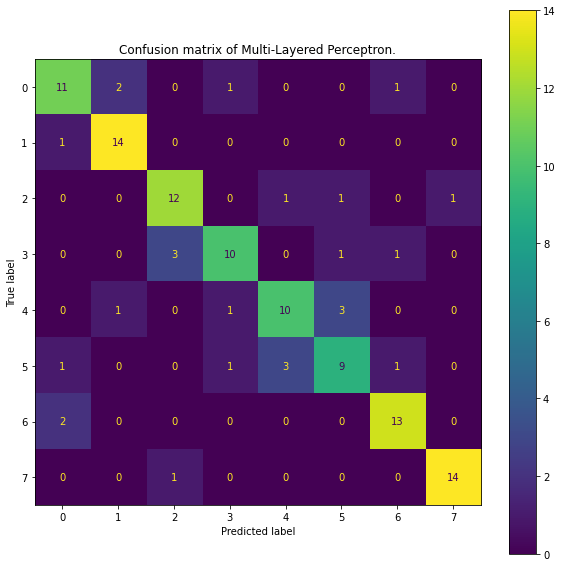

In [ ]:
y_pred = np.argmax(classifier.predict(cnn_test_x), axis=1)
print(f'General accuracy: {accuracy_score(uwave_df_test_y, y_pred)}')
print(f'Precision: {precision_score(uwave_df_test_y, y_pred, average=None)}')
print(f'Recall: {recall_score(uwave_df_test_y, y_pred, average=None)}')
print(f'F1: {f1_score(uwave_df_test_y, y_pred, average=None)}')
print('\n\n')
plt.figure(figsize=(10, 10))
plt.title(f'Confusion matrix of Multi-Layered Perceptron.')
ax = plt.axes()
ConfusionMatrixDisplay(confusion_matrix(uwave_df_test_y, y_pred)).plot(ax=ax)
plt.show()

## LSTM Network

In [ ]:
classifier = Sequential()
classifier.add(LSTM(256, input_shape=(315, 3)))
classifier.add(Dense(64, activation='relu'))
classifier.add(Dense(8, activation='softmax'))
classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = classifier.fit(cnn_train_x, cnn_train_y, epochs=25, batch_size=16)

Epoch 1/25
20/20 [==============================] - 24s 1s/step - loss: 1.7885 - accuracy: 0.2375
Epoch 2/25
20/20 [==============================] - 14s 688ms/step - loss: 1.4486 - accuracy: 0.4125
Epoch 3/25
20/20 [==============================] - 14s 703ms/step - loss: 1.3718 - accuracy: 0.4875
Epoch 4/25
20/20 [==============================] - 14s 692ms/step - loss: 1.2414 - accuracy: 0.5188
Epoch 5/25
20/20 [==============================] - 15s 729ms/step - loss: 1.3096 - accuracy: 0.4938
Epoch 6/25
20/20 [==============================] - 14s 698ms/step - loss: 1.1203 - accuracy: 0.5594
Epoch 7/25
20/20 [==============================] - 14s 682ms/step - loss: 1.1673 - accuracy: 0.5594
Epoch 8/25
20/20 [==============================] - 14s 710ms/step - loss: 1.0919 - accuracy: 0.5813
Epoch 9/25
20/20 [==============================] - 15s 741ms/step - loss: 1.1229 - accuracy: 0.5813
Epoch 10/25
20/20 [==============================] - 14s 696ms/step - loss: 1.0766 - accuracy:

In [ ]:
results = classifier.evaluate(cnn_test_x, cnn_test_y, verbose = 0)
print(f'Results on test set: loss={results[0]}, acc={results[1]}')

Results on test set: loss=1.1786282062530518, acc=0.6333333253860474


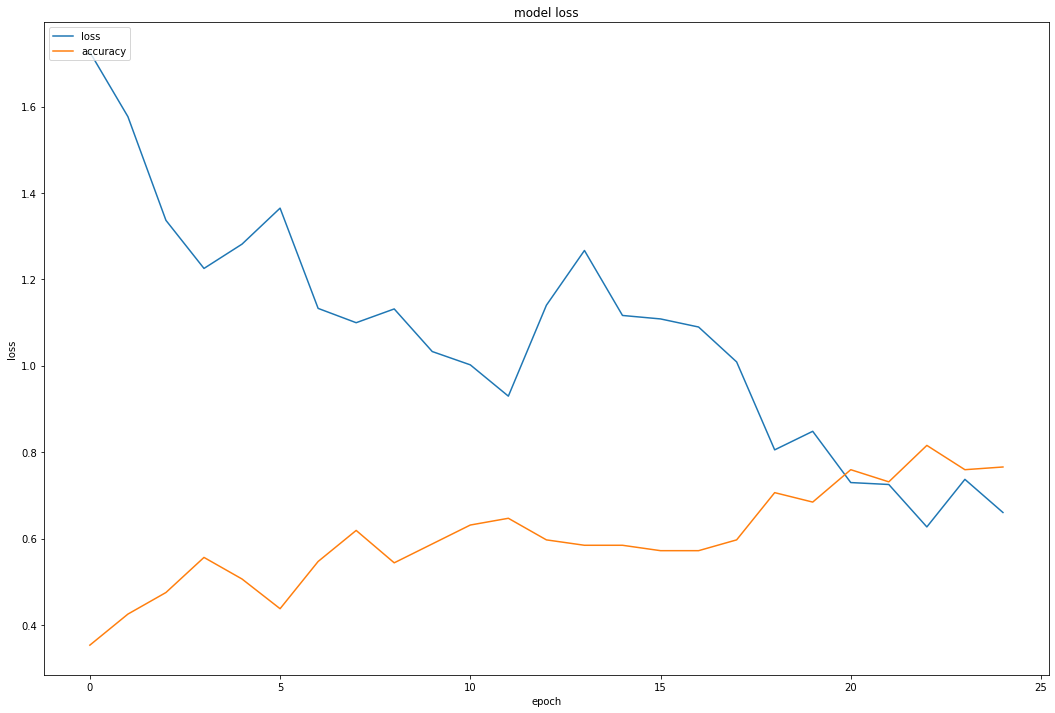

In [ ]:
plt.figure(figsize=(18,12))
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'], loc='upper left')
plt.show()

General accuracy: 0.65
Precision: [0.52631579 0.66666667 0.59090909 0.85714286 0.78947368 0.33333333
 0.66666667 0.5625    ]
Recall: [0.66666667 0.8        0.86666667 0.8        1.         0.06666667
 0.4        0.6       ]
F1: [0.58823529 0.72727273 0.7027027  0.82758621 0.88235294 0.11111111
 0.5        0.58064516]





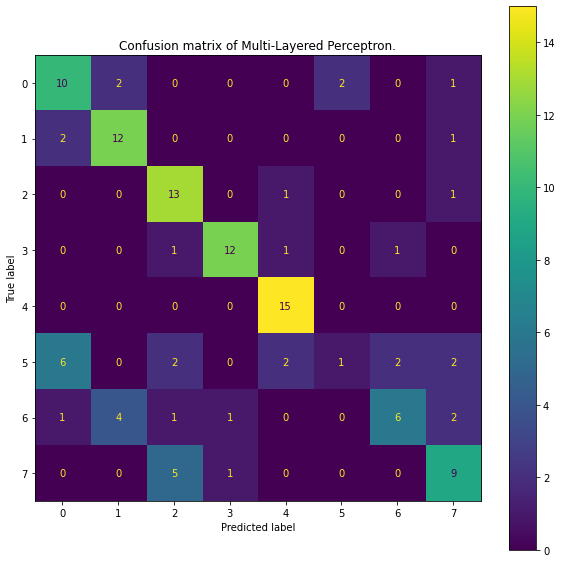

In [ ]:
y_pred = np.argmax(classifier.predict(cnn_test_x), axis=1)
print(f'General accuracy: {accuracy_score(uwave_df_test_y, y_pred)}')
print(f'Precision: {precision_score(uwave_df_test_y, y_pred, average=None)}')
print(f'Recall: {recall_score(uwave_df_test_y, y_pred, average=None)}')
print(f'F1: {f1_score(uwave_df_test_y, y_pred, average=None)}')
print('\n\n')
plt.figure(figsize=(10, 10))
plt.title(f'Confusion matrix of Multi-Layered Perceptron.')
ax = plt.axes()
ConfusionMatrixDisplay(confusion_matrix(uwave_df_test_y, y_pred)).plot(ax=ax)
plt.show()